In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                            roc_auc_score, roc_curve, precision_recall_curve, auc)

# Загрузка данных
file_path = 'C:/Users/Lu Eliseeva/Desktop/DS/Данные/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
df_original = df.copy()  # Сохраняем оригинальную копию

# Проверка данных
print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

Размер данных: (7043, 21)

Первые 5 строк:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

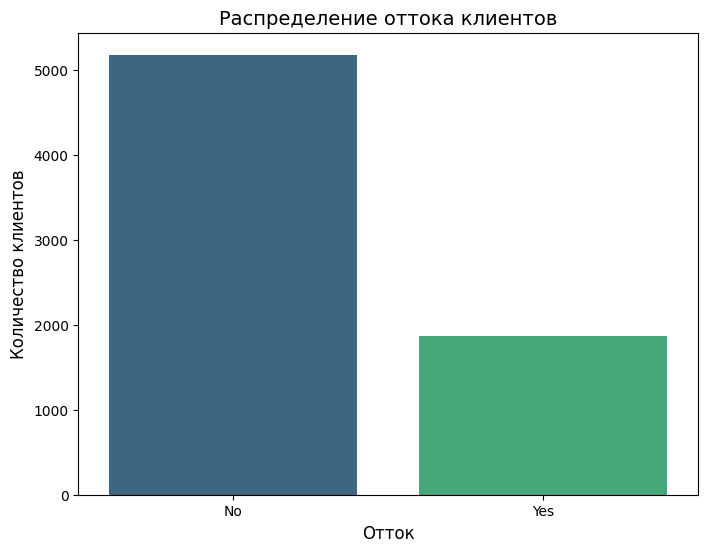

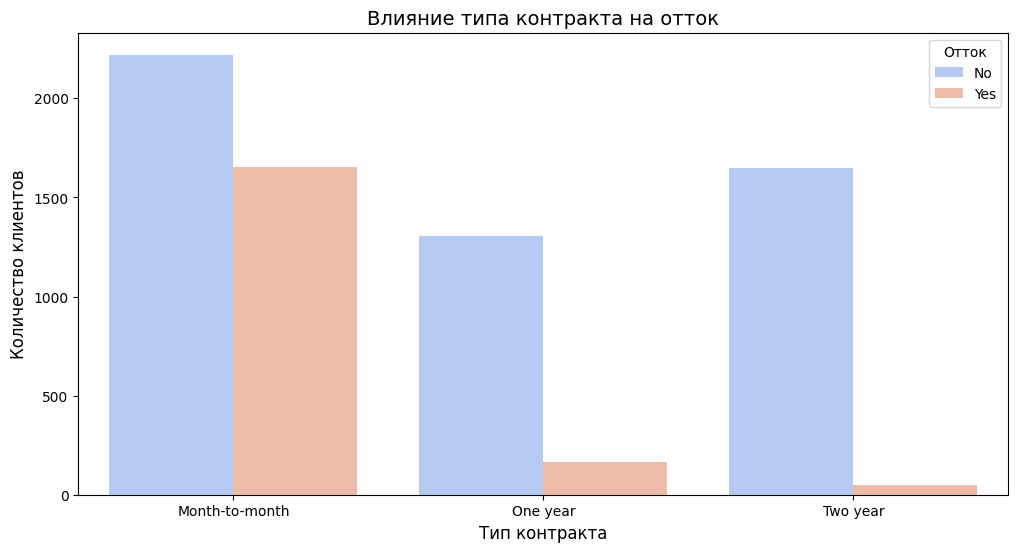

In [4]:
# 1. Визуализация распределения оттока
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df, hue='Churn', palette='viridis', legend=False)
plt.title('Распределение оттока клиентов', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

# 2. Влияние контракта на отток
plt.figure(figsize=(12, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='coolwarm')
plt.title('Влияние типа контракта на отток', fontsize=14)
plt.xlabel('Тип контракта', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(title='Отток')
plt.show()


In [5]:
# 3. Обработка данных
# Проверка наличия столбца перед удалением
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
else:
    print("Столбец 'customerID' не найден. Пропускаем удаление.")

# Преобразование TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Обработка пропущенных значений
print("\nПропущенные значения до обработки:")
print(df.isnull().sum())

df = df.dropna()  # Удаление строк с пропусками

print("\nПропущенные значения после обработки:")
print(df.isnull().sum())

# Преобразование целевой переменной
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Бинарные признаки
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})



Пропущенные значения до обработки:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Пропущенные значения после обработки:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# 4. Подготовка данных для моделирования
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмеры данных:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# 5. Преобразование признаков
# Определение числовых и категориальных столбцов
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Создание преобразователя
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_cols),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Применение преобразований
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)



Размеры данных:
Обучающая выборка: (5625, 19)
Тестовая выборка: (1407, 19)


In [7]:
# 6. Обучение и оценка моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # Исправление: убрали устаревший параметр use_label_encoder
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []
feature_importances = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Обучение модели: {name}")
    
    # Обучение модели
    model.fit(X_train_transformed, y_train)
    
    # Прогнозы
    y_pred = model.predict(X_test_transformed)
    y_proba = model.predict_proba(X_test_transformed)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Расчет метрик
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Расчет дополнительных метрик, если доступны вероятности
    if y_proba is not None:
        auc_roc = roc_auc_score(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
    else:
        auc_roc = None
        pr_auc = None
    
    # Сохранение результатов
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score'],
        'AUC_ROC': auc_roc,
        'PR_AUC': pr_auc
    })
    
    # Вывод результатов
    print(f"\nРезультаты для {name}:")
    print(f"Accuracy: {acc:.4f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.4f}")
    if pr_auc is not None:
        print(f"PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, y_pred))
    


Обучение модели: Logistic Regression

Результаты для Logistic Regression:
Accuracy: 0.8045
AUC-ROC: 0.8359
PR AUC: 0.6208
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407


Обучение модели: Random Forest

Результаты для Random Forest:
Accuracy: 0.7932
AUC-ROC: 0.8123
PR AUC: 0.5945
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Обучение модели: XGBoost

Результаты для XGBoost:
Accuracy: 0.7669
AUC-ROC: 0.8088
PR AUC: 0.6099
             

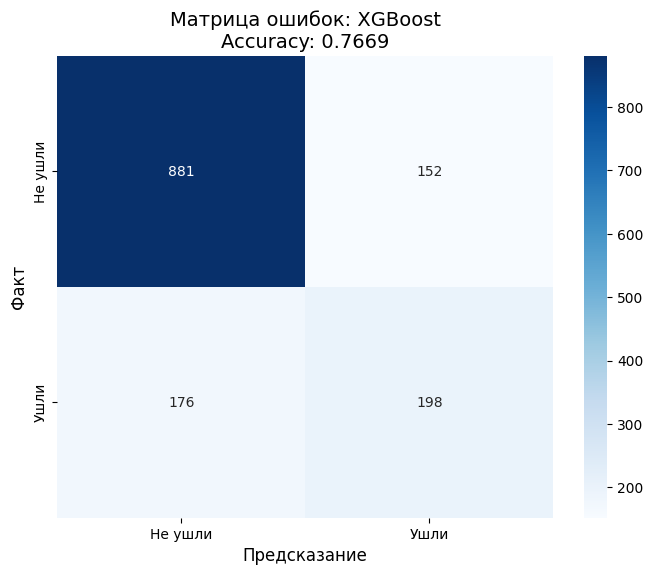

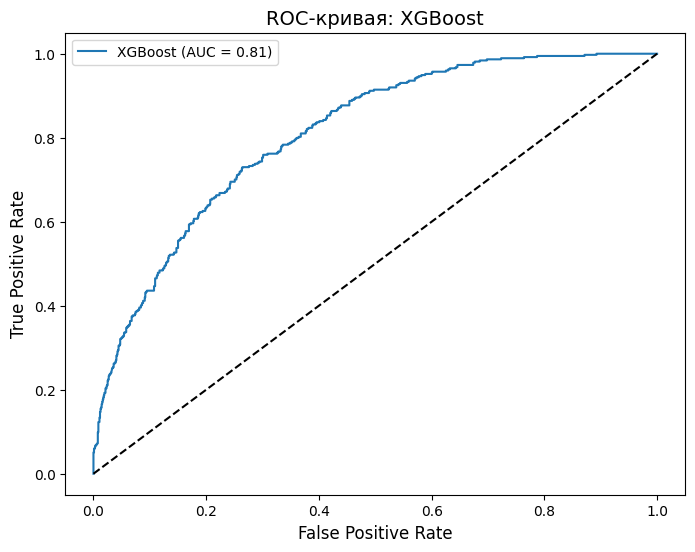


Сравнение моделей:
                 Model  Accuracy  Precision_1  Recall_1      F1_1   AUC_ROC  \
0  Logistic Regression  0.804549     0.649547  0.574866  0.609929  0.835893   
1        Random Forest  0.793177     0.645614  0.491979  0.558422  0.812283   
2              XGBoost  0.766880     0.565714  0.529412  0.546961  0.808840   

     PR_AUC  
0  0.620826  
1  0.594479  
2  0.609942  


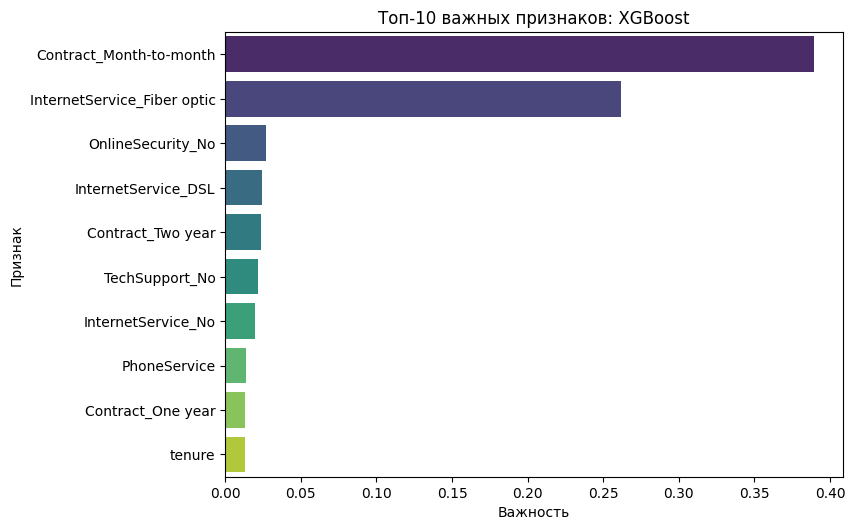

In [8]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не ушли', 'Ушли'],
            yticklabels=['Не ушли', 'Ушли'])
plt.title(f'Матрица ошибок: {name}\nAccuracy: {acc:.4f}', fontsize=14)
plt.xlabel('Предсказание', fontsize=12)
plt.ylabel('Факт', fontsize=12)
plt.show()

# ROC-кривая 
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC-кривая: {name}', fontsize=14)
    plt.legend()
    plt.show()

# Важность признаков (для tree-based моделей)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = numerical_cols + list(preprocessor.named_transformers_['encoder'].get_feature_names_out(categorical_cols))
    feature_importances[name] = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]

# 7. Сравнение моделей
metrics_df = pd.DataFrame(results)
print("\n" + "="*50)
print("Сравнение моделей:")
print(metrics_df)

# 8. Важность признаков
if feature_importances:
    plt.figure(figsize=(15, 10))
    for i, (name, importances) in enumerate(feature_importances.items(), 1):
        plt.subplot(2, 2, i)
        sns.barplot(x=importances.values, y=importances.index, 
                    hue=importances.index, palette='viridis', legend=False)
        plt.title(f'Топ-10 важных признаков: {name}', fontsize=12)
        plt.xlabel('Важность', fontsize=10)
        plt.ylabel('Признак', fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
# 9. Дополнительный анализ
# Влияние срока обслуживания на отток
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df, 
            hue='Churn', palette='coolwarm', legend=False)
plt.title('Влияние срока обслуживания на отток', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Срок обслуживания (мес.)', fontsize=12)
plt.show()

# Влияние ежемесячных платежей
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', 
            fill=True, palette='viridis', alpha=0.6)
plt.title('Распределение ежемесячных платежей по оттоку', fontsize=14)
plt.xlabel('Ежемесячные платежи', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.show()

# Сохранение результатов
metrics_df.to_csv('model_results.csv', index=False)
print("\nРезультаты сохранены в файл 'model_results.csv'")